In [1]:
import itertools as it

from matplotlib import pyplot as plt
from nbmetalog import nbmetalog as nbm
import numpy as np
import pandas as pd
import seaborn as sns
from teeplot import teeplot as tp

import pylib


In [2]:
nbm.print_metadata()


context: local
hostname: thinkpad
interpreter: 3.10.6 (main, Mar 10 2023, 10:55:28) [GCC 11.3.0]
nbcellexec: null
nbname: gene-selection-inference-stats
nbpath: /home/mmore500/2023-05-30/notebooks/notebooks/gene-selection-inference-stats.ipynb
revision: null
session: e4b5585a-d496-492b-b86c-96e363e255b5
timestamp: 2023-05-30T17:08:49Z00:00


IPython==7.31.1
keyname==0.5.2
yaml==6.0
matplotlib==3.6.2
nbmetalog==0.2.6
numpy==1.23.5
pandas==1.5.2
seaborn==0.12.1
teeplot==0.5.0
re==2.2.1
debugpy==1.6.6
logging==0.5.1.2
psutil==5.9.0
zmq==22.3.0
json==2.0.9
ipykernel==6.7.0


In [3]:
df = pylib.util.concat_dataframes_from_glob(
    "a=prevalence-annotation-by-generation+*+ext=.csv"
)


In [4]:
df


,Unnamed: 0,notebook,replicate,fitness-advantage,generation,prevalence,annotation
0,0,gene-selection-inference,9,0.0,0,0,1
1,1,gene-selection-inference,9,0.0,1,0,1
2,2,gene-selection-inference,9,0.0,2,0,1
3,3,gene-selection-inference,9,0.0,3,0,1
4,4,gene-selection-inference,9,0.0,4,0,1
...,...,...,...,...,...,...,...
5995,195,gene-selection-inference,4,0.1,195,400,0
5996,196,gene-selection-inference,4,0.1,196,400,0
5997,197,gene-selection-inference,4,0.1,197,400,0
5998,198,gene-selection-inference,4,0.1,198,400,0


teeplots/./col=fitness-advantage+viz=facet-lineplot-twiny+x=generation+y1=prevalence+y2=annotation+ext=.pdf
teeplots/./col=fitness-advantage+viz=facet-lineplot-twiny+x=generation+y1=prevalence+y2=annotation+ext=.png


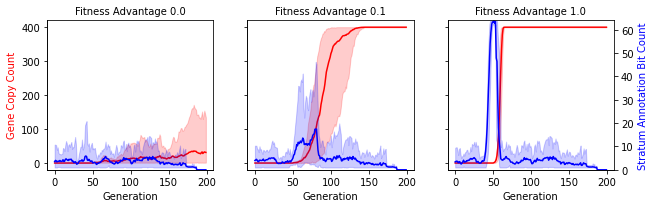

In [5]:
def lineplot_twiny(x, y1, y2, color=None, y2_lims=None, **kwargs):
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    ax1.twin = ax2

    sns.lineplot(x=x, y=y1, color="red", ax=ax1, errorbar="pi")
    sns.lineplot(x=x, y=y2, color="blue", ax=ax2, errorbar="pi")
    ax2.set_ylabel("")

    if y2_lims is not None:
        ax2.set_ylim(*y2_lims)


def facet_lineplot_twiny(data, x, y1, y2, col):
    y2_min = data[y2].min()
    y2_max = data[y2].max()

    g = sns.FacetGrid(data, col=col)
    g.map(lineplot_twiny, x, y1, y2, y2_lims=(y2_min, y2_max), sharey=True)
    g.set_axis_labels("Generation", "")
    # Use set_titles() to format the titles of subplots
    g.set_titles("Fitness Advantage {col_name}")
    g.axes.flat[0].set_ylabel("Gene Copy Count", color="red")
    last_twinx = g.axes.flat[-1].twin
    last_twinx.set_ylabel("Stratum Annotation Bit Count", color="blue")
    for ax in g.axes.flat[:-1]:
        ax.twin.set_yticks([])


tp.tee(
    facet_lineplot_twiny,
    data=df,
    x="generation",
    y1="prevalence",
    y2="annotation",
    col="fitness-advantage",
)


In [6]:
rolling = (
    df.copy()
    .sort_values("generation", axis=0)
    .groupby(["replicate", "fitness-advantage"])["annotation"]
    .rolling(16)
    .sum()
    .reset_index()
)
rolling


,replicate,fitness-advantage,level_2,annotation
0,0,0.0,2800,NaN
1,0,0.0,2801,NaN
2,0,0.0,2802,NaN
3,0,0.0,2803,NaN
4,0,0.0,2804,NaN
...,...,...,...,...
5995,9,1.0,5195,7.0
5996,9,1.0,5196,6.0
5997,9,1.0,5197,5.0
5998,9,1.0,5198,4.0


teeplots/./hue=fitness-advantage+viz=lineplot-detection+x=threshold+y=replicate-count+ext=.pdf
teeplots/./hue=fitness-advantage+viz=lineplot-detection+x=threshold+y=replicate-count+ext=.png


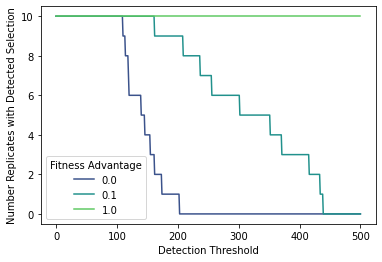

In [7]:
records = []
for threshold, fitness_advantage in it.product(
    range(501), rolling["fitness-advantage"].unique()
):
    count_above_threshold = rolling[
        (rolling["fitness-advantage"] == fitness_advantage)
        & (rolling["annotation"] >= threshold)
    ]["replicate"].nunique()
    records.append(
        {
            "threshold": threshold,
            "replicate_count": count_above_threshold,
            "fitness-advantage": fitness_advantage,
        },
    )

above_threshold_df = pd.DataFrame.from_records(records)


def lineplot_detection(data, x, y, hue):
    sns.lineplot(
        data,
        x=x,
        y=y,
        hue=hue,
        palette=sns.color_palette("viridis", 3),
    )

    plt.xlabel("Detection Threshold")
    plt.ylabel("Number Replicates with Detected Selection")
    plt.legend(title="Fitness Advantage")


tp.tee(
    lineplot_detection,
    data=above_threshold_df,
    x="threshold",
    y="replicate_count",
    hue="fitness-advantage",
)
